<a href="https://colab.research.google.com/github/dannynacker/roX_gen/blob/main/roX_gen_dither.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script generates periodic or aperiodic waveforms of matched flash counts and total on durations SPECIFIC to the parameter constraints set forth by WP1 (3 - 15 Hz, 25 - 75 % Duty Cycle).

1. Ask for the number of steps overall in the sequence.

2. For each step, it will ask for:

  2a. Duration in seconds

  2b. Periodicity (p vs. a)

  2c. Start and End Frequency (Hz; 3 to 15)

  2d. Start and End Duty Cycle (%; 25 to 75)

  2e. Start and End Luminance (0 to 100)
  
  2f. Wave Type (0 = OFF, 1 = SQUARE, 2 = SINE)

These values are assigned to all four LEDs to the first roX oscillator, while the other three oscillators are set to OFF.

For each step, these values are stored in step_params. The script also prepares a bin to store flash counts of the periodic step (for help in generating a matched aperiodic step) as well as their on times. These are used to generate a list of interflash intervals, which are plotted for the sequence at the end of the script. As such, to aid in visualization, I recommend using this script to only generate two steps at a time (compare the periodic and aperiodic versions of the step you wish to build) -- you can easily append additional STP lines on top of each other later, and manually or automatically correct the TIM and DUR stamps at the top of the completed roX .txt file.

For each step, mean frequency and duty cycle are computed, as well as the total number of flashes (based on these means) and the expected total on duration (based on the above three variables).

If a step is PERIODIC, we only produce one STP line, as its duration is likely much longer than the device's minimum (100ms) and as such the device is capable of linearly interpolating across start and end values for frequency, duty cycle, and luminance WITHIN an STP line; this is not true for very granular STP lengths, such as the 100ms minimum that we enforce for matched aperiodic wave generation.

If a step is APERIODIC, this script draws from the calculated expected flashes and on time from a matched periodic wave, and attempts to generate over a series of trials to find good candidates for frequency and duty cycle (clamped to the parameter range set forth by WP1) which allow for matched flash counts and on durations, while penalizing "boundary hits" (i.e., a flash frequency of 3 or 15, or a duty cycle of 25 or 75) so that the script doesn't force-match wave characteristics too early and have to fill the rest of the period with boundary dynamics (i.e., multiple 3 Hz flashes at varying duty cycles to try to adhere to matching the periodic wave). This ensures that the maximum amount of jitter can be applied to a step specific to the parameters within that step. This is done over a specified number of trials (currently set to 1000) and a particular threshold for matching on duration (currently set to 10ms).

Eventually, duty cycle and frequency end their dance together, and matched flash counts and on durations are found, so the script moves on to formatting these steps into roX language.

RoX language is probably copyrighted, so that will not be explained here.

The interflash intervals between the waves are then plotted and overlayed so one can see the narrow interval of the periodic wave (a cluster around 1 / mean_freq) compared to the jittered distribution of a matched aperiodic wave (assuming you created the same periodic and aperiodic waveform).

Future updates will include the automatic production of a step of opposing periodicity (so that two steps don't have to be manually generated each time for variability comparison), but, without verification of aperiodicity from a photodiode, we will allow for step-by-step, periodicity-by-periodicity manual verification of jittered interval distribution.

Enter the number of steps in the sequence: 2
Step 1:
  Enter step duration (seconds): 60
  Enter periodicity (p=Periodic, a=Aperiodic): p
  Enter start frequency (Hz): 3
  Enter end frequency (Hz): 15
  Enter start duty cycle (1-99): 25
  Enter end duty cycle (1-99): 75
  Enter start luminance (0-100): 50
  Enter end luminance (0-100): 50
  Enter wave type (0=Off, 1=Square, 2=Sine): 1
Step 1 (Periodic) | Duration: 60.0s | Flash Count: 540 | ON-Time: 30.00s
Step 2:
  Enter step duration (seconds): 60
  Enter periodicity (p=Periodic, a=Aperiodic): a
  Enter start frequency (Hz): 3
  Enter end frequency (Hz): 15
  Enter start duty cycle (1-99): 25
  Enter end duty cycle (1-99): 75
  Enter start luminance (0-100): 50
  Enter end luminance (0-100): 50
  Enter wave type (0=Off, 1=Square, 2=Sine): 1
Step 2 (Aperiodic) | Duration: 60.0s | Expected Flash Count: 540 | Expected ON-Time: 30.00s
  => Aperiodic actual flash count: 540, actual ON-Time: 30.00s
Generated strobe_sequence.txt


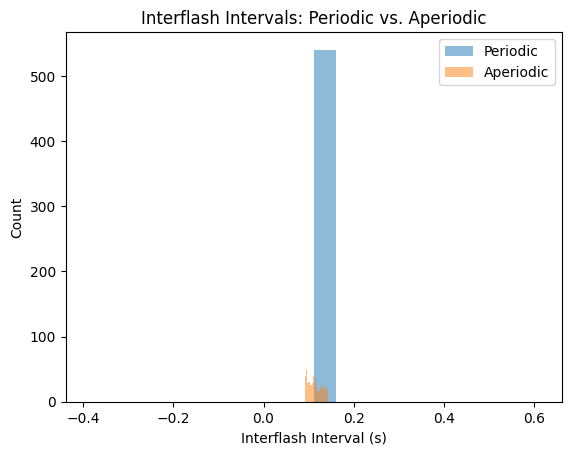

In [12]:
import random
import matplotlib.pyplot as plt

def format_time(total_seconds):
    """Formats TIM as hh:mm:ss.s with leading zeros."""
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"00:{minutes:02}:{seconds:02}.{int(fraction * 10)}"

def format_stp(step_duration, wave_type, freq, duty, led_assignments, intensity):
    """
    Formats a single STP line.
    For oscillator 0, freq and duty are 2-element lists: [start, end],
    and intensity is [start, end]. Other oscillators are off.
    """
    blocks = []
    for osc in range(4):
        if osc == 0:
            block = (f"{wave_type},"
                     f"{freq[0]:.2f},{freq[1]:.2f},"
                     f"{duty[0]},{duty[1]},"
                     f"{','.join(map(str, led_assignments[osc]))},"
                     f"{intensity[0]},{intensity[1]}")
        else:
            block = (f"0,{freq[0]:.2f},{freq[0]:.2f},"
                     f"{duty[0]},{duty[0]},"
                     "0,0,0,0,0,0")
        blocks.append(block)
    return f"STP\"{max(step_duration, 0.1):.1f},{','.join(blocks)}\""

def get_led_assignments():
    """Automatically assigns all LEDs on for the first oscillator and off for the others."""
    return [[1, 1, 1, 1]] + [[0, 0, 0, 0] for _ in range(3)]

def generate_candidate_flash_params(mean_freq, mean_duty, num_flashes, jitter_range_freq, jitter_range_duty, trials=20):
    """
    Generates multiple candidate sets of jittered flash parameters (centered around the mean)
    and returns the candidate with the fewest hits at the boundaries.
    Each candidate is a list of tuples: (flash_freq, flash_duty, on_duration).
    """
    best_candidate = None
    best_cost = float('inf')
    for _ in range(trials):
        candidate = []
        cost = 0
        for _ in range(num_flashes):
            flash_freq_raw = random.uniform(mean_freq - jitter_range_freq, mean_freq + jitter_range_freq)
            flash_freq = max(3, min(15, flash_freq_raw))
            flash_duty_raw = random.randint(int(mean_duty - jitter_range_duty), int(mean_duty + jitter_range_duty))
            flash_duty = max(25, min(75, flash_duty_raw))
            on_duration = (1 / flash_freq) * (flash_duty / 100)
            candidate.append((flash_freq, flash_duty, on_duration))
            if flash_freq == 3 or flash_freq == 15:
                cost += 1
            if flash_duty == 25 or flash_duty == 75:
                cost += 1
        if cost < best_cost:
            best_cost = cost
            best_candidate = candidate
    return best_candidate

def generate_strobe_sequence():
    """
    Generates periodic and aperiodic STP sequences while ensuring matched flash counts and ON-times.

    For each step, the expected flash count is:
         total_flashes = duration * mean_freq
    and the expected ON-time is:
         expected_on_time = total_flashes * (1/mean_freq) * (mean_duty/100)

    In the aperiodic branch, candidate flash parameters are generated using jitter centered around
    the mean frequency and mean duty. An iterative scaling loop then adjusts the duty cycles so that
    the sum of ON-times nearly matches the expected value. Additionally, luminance is linearly
    interpolated from start to end over the entire step.

    Finally, interflash intervals for both periodic and aperiodic conditions are recorded and plotted.
    """
    num_steps = int(input("Enter the number of steps in the sequence: "))
    step_params = []
    periodic_flash_counts = []
    periodic_on_times = []
    periodic_intervals = []   # For periodic: constant intervals
    aperiodic_intervals = []  # For aperiodic: variable intervals

    for i in range(num_steps):
        print(f"Step {i + 1}:")
        duration = float(input("  Enter step duration (seconds): "))
        periodicity = input("  Enter periodicity (p=Periodic, a=Aperiodic): ").strip().lower()
        start_freq = float(input("  Enter start frequency (Hz): "))
        end_freq = float(input("  Enter end frequency (Hz): "))
        start_d = int(input("  Enter start duty cycle (1-99): "))
        end_d = int(input("  Enter end duty cycle (1-99): "))
        start_l = int(input("  Enter start luminance (0-100): "))
        end_l = int(input("  Enter end luminance (0-100): "))
        wave_type = int(input("  Enter wave type (0=Off, 1=Square, 2=Sine): "))

        led_config = get_led_assignments()

        mean_freq = (start_freq + end_freq) / 2
        mean_duty = (start_d + end_d) / 2
        total_flashes = int(duration * mean_freq)
        expected_on_time = total_flashes * (1 / mean_freq) * (mean_duty / 100)

        step_params.append((duration, periodicity, start_freq, end_freq, start_d, end_d, start_l, end_l, wave_type, led_config))

        if periodicity == "p":
            periodic_flash_counts.append(total_flashes)
            periodic_on_times.append(expected_on_time)
            print(f"Step {i + 1} (Periodic) | Duration: {duration:.1f}s | Flash Count: {total_flashes} | ON-Time: {expected_on_time:.2f}s")
            periodic_intervals.extend([1 / mean_freq] * total_flashes)

    output = [f'TIM"{format_time(sum(step[0] for step in step_params)).strip()}\"',
              f'DUR"{sum(step[0] for step in step_params):.1f}\"']

    periodic_index = 0
    for step_idx, step in enumerate(step_params):
        (duration, periodicity, start_freq, end_freq, start_d, end_d, start_l, end_l, wave_type, led_config) = step
        mean_freq = (start_freq + end_freq) / 2
        mean_duty = (start_d + end_d) / 2
        total_flashes = int(duration * mean_freq)
        expected_on_time = total_flashes * (1 / mean_freq) * (mean_duty / 100)

        if periodicity == "p":
            stp_line = format_stp(
                duration, wave_type,
                [start_freq, end_freq, start_freq, end_freq],
                [start_d, end_d, start_d, end_d],
                led_config,
                [start_l, end_l, start_l, end_l]
            )
            output.append(stp_line)
        else:
            expected_flashes = periodic_flash_counts[periodic_index]
            expected_on_time = periodic_on_times[periodic_index]
            periodic_index += 1

            print(f"Step {step_idx + 1} (Aperiodic) | Duration: {duration:.1f}s | Expected Flash Count: {expected_flashes} | Expected ON-Time: {expected_on_time:.2f}s")

            # Generate candidate flash parameters centered around the mean values.
            candidate = generate_candidate_flash_params(mean_freq, mean_duty, expected_flashes, jitter_range_freq=2, jitter_range_duty=20, trials=1000)
            for flash_freq, _, _ in candidate:
                aperiodic_intervals.append(1 / flash_freq)

            # Iterative scaling of duty cycles to match expected ON-time.
            max_iterations = 5
            tolerance = 0.01
            for iteration in range(max_iterations):
                actual_on_time = sum(x[2] for x in candidate)
                diff = abs(actual_on_time - expected_on_time)
                if diff <= tolerance:
                    break
                k = expected_on_time / actual_on_time if actual_on_time != 0 else 1
                new_candidate = []
                for flash_freq, flash_duty, _ in candidate:
                    new_duty = flash_duty * k
                    new_duty = max(25, min(75, new_duty))
                    new_on = (1 / flash_freq) * (new_duty / 100)
                    new_candidate.append((flash_freq, new_duty, new_on))
                candidate = new_candidate

            actual_flash_count = len(candidate)
            actual_on_time = sum(x[2] for x in candidate)
            print(f"  => Aperiodic actual flash count: {actual_flash_count}, actual ON-Time: {actual_on_time:.2f}s")

            # For linear luminance interpolation, compute an intensity value per flash based on its index.
            adjusted_candidate = []
            for idx, (flash_freq, flash_duty, on_duration) in enumerate(candidate):
                if expected_flashes > 1:
                    interp_intensity = start_l + (end_l - start_l) * (idx / (expected_flashes - 1))
                else:
                    interp_intensity = start_l
                adjusted_candidate.append((flash_freq, flash_duty, on_duration, interp_intensity))

            # Generate STP lines for each flash using the interpolated luminance.
            for flash_freq, flash_duty, on_duration, interp_intensity in adjusted_candidate:
                stp_line = format_stp(
                    0.1,
                    wave_type,
                    [flash_freq, flash_freq, flash_freq, flash_freq],
                    [flash_duty, flash_duty, flash_duty, flash_duty],
                    led_config,
                    [interp_intensity, interp_intensity, interp_intensity, interp_intensity]
                )
                output.append(stp_line)

    with open("strobe_sequence.txt", "w", encoding="utf-8", newline="") as f:
        f.write("\r\n".join(output))
    print("Generated strobe_sequence.txt")

    # Plot overlayed histograms of interflash intervals:
    plt.hist(periodic_intervals, bins=20, alpha=0.5, label="Periodic")
    plt.hist(aperiodic_intervals, bins=20, alpha=0.5, label="Aperiodic")
    plt.xlabel("Interflash Interval (s)")
    plt.ylabel("Count")
    plt.title("Interflash Intervals: Periodic vs. Aperiodic")
    plt.legend()
    plt.show()

generate_strobe_sequence()